## Import Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

## Load in the intermideate datasets created by the data processing scripts

This data has the CGM values exploded out such that each timestamp entity has its own row

In [3]:
train_path = './dinnerInclusive_featurizedDataset.csv'
train_set = pd.read_csv(train_path)

,Unnamed: 0,SubjectID,Day,Breakfast Time,Lunch Time,Dinner Time,Glucose Timestamp,Glucose Value,Breakfast Calories,Breakfast Carbs,...,PCA_3,PCA_4,PCA_5,Time to Breakfast,Time Past Breakfast,Time to Lunch,Time Past Lunch,Time to Dinner,Time Past Dinner,Smoothed Glucose Value
0,0,1,1,08:18:00,14:23:00,20:48:00,10:30:00,84.000000,448.0,66.0,...,-1.490834,0.753451,0.283034,00:00:00,02:12:00,03:53:00,00:00:00,10:18:00,00:00:00,84.154893
1,1,1,1,08:18:00,14:23:00,20:48:00,10:31:00,84.133333,448.0,66.0,...,-1.490834,0.753451,0.283034,00:00:00,02:13:00,03:52:00,00:00:00,10:17:00,00:00:00,84.204961
2,2,1,1,08:18:00,14:23:00,20:48:00,10:32:00,84.266667,448.0,66.0,...,-1.490834,0.753451,0.283034,00:00:00,02:14:00,03:51:00,00:00:00,10:16:00,00:00:00,84.294633
3,3,1,1,08:18:00,14:23:00,20:48:00,10:33:00,84.400000,448.0,66.0,...,-1.490834,0.753451,0.283034,00:00:00,02:15:00,03:50:00,00:00:00,10:15:00,00:00:00,84.409070
4,4,1,1,08:18:00,14:23:00,20:48:00,10:34:00,84.533333,448.0,66.0,...,-1.490834,0.753451,0.283034,00:00:00,02:16:00,03:49:00,00:00:00,10:14:00,00:00:00,84.535742


## Adding ratio  columns 

In [4]:
print(train_set.columns)

#train_set['Carb_Protein_Ratio'] = train_set['Lunch Carbs'] / train_set['Lunch Protein']
#train_set['Carb_Fat_Ratio'] = train_set['Lunch Carbs'] / train_set['Lunch Fat']

#test_set['Carb_Protein_Ratio'] = test_set['Lunch Carbs'] / test_set['Lunch Protein']
#test_set['Carb_Fat_Ratio'] = test_set['Lunch Carbs'] / test_set['Lunch Fat']


Index(['Unnamed: 0', 'SubjectID', 'Day', 'Breakfast Time', 'Lunch Time',
       'Dinner Time', 'Glucose Timestamp', 'Glucose Value',
       'Breakfast Calories', 'Breakfast Carbs', 'Breakfast Protein',
       'Breakfast Fat', 'Breakfast Fiber', 'Lunch Calories', 'Lunch Carbs',
       'Lunch Protein', 'Lunch Fat', 'Lunch Fiber', 'Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber',
       'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose',
       'Median Glucose', 'Range Glucose', 'CV Glucose', 'Max Rate Increase',
       'Max Rate Decrease', 'Time to Peak', 'Time to Nadir', 'PCA_1', 'PCA_2',
       'PCA_3', 'PCA_4', 'PCA_5', 'Time to Breakfast', 'Time Past Breakfast',
       'Time to Lunch', 'Time Past Lunch', 'Time to Dinner',
       'Time Past Dinner', 'Smoothed Glucose Value'],
      dtype='object')


## Convert time values to seconds for numerical nterpretation

In [7]:
def time_to_seconds(t):
    if isinstance(t, str):
        h, m, s = map(int, t.split(':'))
        return h * 3600 + m * 60 + s
    return t

time_columns = ['Breakfast Time', 'Lunch Time', 'Dinner Time','Glucose Timestamp', 'Time to Peak', 'Time to Nadir', 'Time to Breakfast', 'Time Past Breakfast',  'Time to Lunch',  'Time Past Lunch','Time to Dinner',
       'Time Past Dinner']
for col in time_columns:
    train_set[col] = train_set[col].apply(time_to_seconds)
    #test_set[col] = test_set[col].apply(time_to_seconds)

#train_set['Date'] = pd.to_datetime(train_set['Date'])
#test_set['Date'] = pd.to_datetime(test_set['Date'])
#start_date = train_set['Date'].min()
#train_set['Date'] = (train_set['Date'] - start_date).dt.days
#test_set['Date'] = (test_set['Date'] - start_date).dt.days

train_set_index = train_set[['SubjectID', 'Day']]
#test_set_index = test_set[['Subject ID', 'Day']]

#train_set = train_set.drop(['Subject ID', 'Day'], axis=1)
#test_set = test_set.drop(['Subject ID', 'Day'], axis=1)

## Scaling :

The preprocessed dataset is not yet scaled. We scale here using a standard scalar for all the appropriate values. We do not scale the Lunch Calories since its the target value. We also do not scale the PCA values since they are already scaled before being generated

In [9]:
#Need to scale dataset here

def scale_datasets(dataset):
    scaler = StandardScaler()

    columns_to_scale = [
        'Breakfast Time', 'Lunch Time','Dinner Time',
        'Breakfast Calories', 'Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein',
        'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose',
        'Median Glucose', 'Range Glucose', 'CV Glucose',
        'Max Rate Increase', 'Max Rate Decrease', 'Time to Peak', 'Time to Nadir'#,'Lunch Calories'
        ,'Glucose Timestamp', 'Smoothed Glucose Value', 'Time to Breakfast', 'Time Past Breakfast',  'Time to Lunch',  'Time Past Lunch','Time to Dinner',
       'Time Past Dinner']


    df_to_scale = dataset[columns_to_scale]  # Extract columns to scale

    # Scale the selected columns
    scaled_columns = scaler.fit_transform(df_to_scale)
    scaled_columns_df = pd.DataFrame(scaled_columns, columns=columns_to_scale)

    # Combine scaled and unscaled parts of the dataset
    unchanged_columns = dataset.drop(columns=columns_to_scale)
    combined_df_scaled = pd.concat([unchanged_columns, scaled_columns_df], axis=1)
    train_set_scaled = combined_df_scaled.copy()
    return train_set_scaled

train_set_scaled = scale_datasets(train_set)
#test_set_scaled = scale_datasets(test_set)


In [10]:
train_set_scaled

,Unnamed: 0,SubjectID,Day,Glucose Value,Breakfast Fiber,Lunch Calories,Lunch Carbs,Lunch Protein,Lunch Fat,Lunch Fiber,...,Time to Peak,Time to Nadir,Glucose Timestamp,Smoothed Glucose Value,Time to Breakfast,Time Past Breakfast,Time to Lunch,Time Past Lunch,Time to Dinner,Time Past Dinner
0,0,1,1,84.000000,0.0,1170.0,85.0,88.0,54.2,12.0,...,1.74553,0.330625,-0.272650,-0.635561,-0.55043,-0.603084,0.172519,-0.763170,0.541988,-0.437946
1,1,1,1,84.133333,0.0,1170.0,85.0,88.0,54.2,12.0,...,1.74553,0.330625,-0.270226,-0.634340,-0.55043,-0.599948,0.168496,-0.763170,0.539280,-0.437946
2,2,1,1,84.266667,0.0,1170.0,85.0,88.0,54.2,12.0,...,1.74553,0.330625,-0.267802,-0.632152,-0.55043,-0.596812,0.164473,-0.763170,0.536572,-0.437946
3,3,1,1,84.400000,0.0,1170.0,85.0,88.0,54.2,12.0,...,1.74553,0.330625,-0.265377,-0.629361,-0.55043,-0.593676,0.160450,-0.763170,0.533864,-0.437946
4,4,1,1,84.533333,0.0,1170.0,85.0,88.0,54.2,12.0,...,1.74553,0.330625,-0.262953,-0.626271,-0.55043,-0.590540,0.156427,-0.763170,0.531155,-0.437946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443654,443654,49,8,82.600000,0.0,585.0,40.0,76.0,17.0,13.0,...,-0.42164,2.148379,1.679002,-0.672639,-0.55043,2.147153,-0.764875,2.181945,-1.131608,1.834287
443655,443655,49,8,82.400000,0.0,585.0,40.0,76.0,17.0,13.0,...,-0.42164,2.148379,1.681426,-0.677778,-0.55043,2.150289,-0.764875,2.186448,-1.131608,1.844905
443656,443656,49,8,82.200000,0.0,585.0,40.0,76.0,17.0,13.0,...,-0.42164,2.148379,1.683851,-0.682153,-0.55043,2.153425,-0.764875,2.190951,-1.131608,1.855523
443657,443657,49,8,82.000000,0.0,585.0,40.0,76.0,17.0,13.0,...,-0.42164,2.148379,1.686275,-0.685490,-0.55043,2.156561,-0.764875,2.195455,-1.131608,1.866141


## Creating validation dataset

In this section we seperate out the data into training and validation datasets. There are a few key design choices at play in this cell. We treat each Subject_Day pair as atomic entity. Meaning Our total dataset contains the number of unique Subject_Day pairings. This is done to avoid any form of data leak. Any particular day's data for a given subject can only exist in train or validation set and not both.


Note : For the moment the Subject ID and Day are still part of the dataset. However they are filtered out before training

In [28]:
#Seperate out target values
y = train_set_scaled[['SubjectID', 'Day', 'Lunch Calories','Lunch Carbs','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber']].drop_duplicates(subset=['SubjectID', 'Day'])
#
#Create unique Subject_Day Pairs

subject_day_pairs = y[['SubjectID', 'Day']].drop_duplicates()
subject_day_pairs = subject_day_pairs[subject_day_pairs['Day'] != 1]

#Distribute these pairs into 80/20 Train/Validation sets
train_pairs, val_pairs = train_test_split(subject_day_pairs, test_size=0.2, random_state=42)

train_pairs_set = set(tuple(x) for x in train_pairs.values)
val_pairs_set = set(tuple(x) for x in val_pairs.values)

# Form Data structures to store the data from these pairs 
train_data_dict_X = []
train_data_dict_y = []
val_data_dict_X = []
val_data_dict_y = []

# Iterate over the  dataframes and filter them based on Subject ID and Day
for index,row in train_set_scaled.iterrows():
    subject_id = row['SubjectID']  # Assuming the key is of the format 'Subject_Day'
    day = row['Day']
    if (subject_id, day) in train_pairs_set:
        train_data_dict_X.append(row.drop(['Breakfast Time', 'Lunch Time','Lunch Carbs', 'Lunch Calories', 'Lunch Fat', 'Lunch Protein','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber'])) #'Subject ID', 'Day',
        train_data_dict_y.append(row[['SubjectID', 'Day','Lunch Calories','Lunch Carbs','Lunch Fat', 'Lunch Protein','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber']])
    elif (subject_id, day) in val_pairs_set:
        val_data_dict_X.append(row.drop(['Breakfast Time', 'Lunch Time','Lunch Carbs', 'Lunch Calories','Lunch Fat', 'Lunch Protein','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber'])) #'Subject ID', 'Day',
        val_data_dict_y.append(row[['SubjectID', 'Day','Lunch Calories','Lunch Carbs','Lunch Fat', 'Lunch Protein','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber']])

# Now, train_data_dict and test_data_dict should contain only the data for the corresponding Subject-Day pairs
train_data_dict_X = pd.DataFrame(train_data_dict_X)
train_data_dict_y = pd.DataFrame(train_data_dict_y)
val_data_dict_X = pd.DataFrame(val_data_dict_X)
val_data_dict_y = pd.DataFrame(val_data_dict_y)


#### For Processing ease we group the individual datasets again into thier subject and day pairs. This makes it easier to process sequence lengths.

In [29]:

def grouping_function(grouped_dataset):
    group_dict = {}
    for group_name, group_data in grouped_dataset:
        group_dict[f"{int(group_name[0])}_{int(group_name[1])}"] = group_data
    return group_dict

grouped_train_X = grouping_function(train_data_dict_X.groupby(['SubjectID','Day']))
grouped_train_y = grouping_function(train_data_dict_y.groupby(['SubjectID','Day']))
grouped_val_X = grouping_function(val_data_dict_X.groupby(['SubjectID','Day']))
grouped_val_y = grouping_function(val_data_dict_y.groupby(['SubjectID','Day']))


#grouped_test_X = grouping_function(test_set_scaled.groupby(['Subject ID','Day']))

### We create a dataset class to pass into data loaders that will be created ahead

We structure our datas into thier static and dynamic components to avoid unecessary repeated values. Our models are also structured to accept the data this way


In [30]:

class CombinedDataset(Dataset):
    def __init__(self, dynamic_data, static_data, targets=None):
        self.dynamic_data = torch.tensor(dynamic_data, dtype=torch.float32)
        self.static_data = torch.tensor(static_data, dtype=torch.float32)
        #self.targets = torch.tensor(targets, dtype=torch.float32) if targets is not None else None
        self.targets = targets if targets is not None else None

    def __len__(self):
        return self.dynamic_data.shape[0]

    def __getitem__(self, idx):
        if self.targets is not None:
            return self.dynamic_data[idx], self.static_data[idx], self.targets[idx]
        return self.dynamic_data[idx], self.static_data[idx]

### We truncate our timesteps to 93 , based on max, min and average number of time steps for the training data.

In [67]:
max_timesteps = 1440


grouped_train_X = {key: df for key, df in grouped_train_X.items() if len(df) == 1440}
grouped_train_y = {key: df for key, df in grouped_train_y.items() if len(df) == 1440}

grouped_val_X = {key: df for key, df in grouped_val_X.items() if len(df) == 1440}
grouped_val_y = {key: df for key, df in grouped_val_y.items() if len(df) == 1440}



y_features = ['Lunch Carbs', 'Lunch Calories','Lunch Fat', 'Lunch Protein','Dinner Calories',
       'Dinner Carbs', 'Dinner Protein', 'Dinner Fat', 'Dinner Fiber']
y_features = ['Lunch Calories','Dinner Calories']

train_data_dict_X_truncated = {
    key: value.iloc[:max_timesteps]  
    for key, value in grouped_train_X.items()
}

val_data_dict_X_truncated = {
    key: value.iloc[:max_timesteps]  
    for key, value in grouped_val_X.items()
}

train_data_dict_y_truncated = {
    key: value.iloc[0][y_features]  
    for key, value in grouped_train_y.items()
}

val_data_dict_y_truncated = {
    key: value.iloc[0][y_features]
    for key, value in grouped_val_y.items()
}

# test_data_dict_X_truncated = { key: value.iloc[:80]  
#     for key, value in grouped_test_X.items()
# }


### We create sequences based on the time steps and generate our static and dynamic inputs

In [68]:
def create_sequences_strict(dynamic_data, static_data, target_data, sequence_length):
    X_dynamic, X_static, y = [], [], []
    print(len(dynamic_data))
    for i in range(len(dynamic_data) // sequence_length):
        X_dynamic.append(dynamic_data[i*sequence_length:(i+1)*sequence_length])
        X_static.append(static_data[i*sequence_length])
        if target_data is not None:
            y.append(target_data[i])
    return np.array(X_dynamic), np.array(X_static), np.array(y)

## Feature Selection

In this part of the code we can specify which features we want to train the model based on. Originally this was part of the grid search. Although we received our best results in terms of RMSRE when we included breakfast macro's I eventually decided to leave them out. This was to generalize our learning process. Based on prior knowledge of the experiment's protocols our hypothesis that including these values would lead to the model overly indexing on them proved to be true based on weight and shapley analysis which is included in the paper.



In [69]:
static_features = [
    #'Breakfast Time', 'Lunch Time',
    #'Breakfast Calories', 'Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein',
    'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose',
    'Median Glucose', 'Range Glucose', 'CV Glucose',
    'Max Rate Increase', 'Max Rate Decrease', 'Time to Peak', 'Time to Nadir',
    'PCA_1',    'PCA_2',     'PCA_3',     'PCA_4',     'PCA_5'
]
target = ['Lunch Calories','Dinner Calories']
dynamic_features = ['Smoothed Glucose Value', 'Time to Breakfast', 'Time Past Breakfast',  'Time to Lunch',  'Time Past Lunch','Time to Dinner',
       'Time Past Dinner']  #'Glucose Timestamp'


## Create datasets for loaders
def create_datasets(X,y,static_features,dynamic_features):
    
    df_all_train_X = pd.concat(X.values(), ignore_index=True)
   
    if y:
        df_all_train_y = pd.DataFrame(list(y.values()))
        X_train_dyn, X_train_stat, y_train_split = create_sequences_strict(df_all_train_X[dynamic_features].values,df_all_train_X[static_features].values,df_all_train_y.values,max_timesteps)
    else :
        X_train_dyn, X_train_stat,y_train_split = create_sequences_strict(df_all_train_X[dynamic_features].values,df_all_train_X[static_features].values,None,max_timesteps)
        y_train_split = None
    return CombinedDataset(X_train_dyn,X_train_stat,y_train_split)

    #return CombinedDataset(df_all_train_X[dynamic_features].values,df_all_train_X[static_features].values,df_all_train_y.values)

train_comined_dataset = create_datasets(train_data_dict_X_truncated,train_data_dict_y_truncated,static_features,dynamic_features)
val_combined_dataset = create_datasets(val_data_dict_X_truncated,val_data_dict_y_truncated,static_features,dynamic_features)
#test_combined_dataset = create_datasets(test_data_dict_X_truncated,None,static_features=static_features,dynamic_features=dynamic_features)

316800
79200


In [70]:
#Create Data loaders from pytorch frameworks using teh data above

train_loader2 = DataLoader(train_comined_dataset, batch_size=8, shuffle=False)
val_loader2 = DataLoader(val_combined_dataset, batch_size=8, shuffle=False)
#test_loader2 = DataLoader(test_combined_dataset, batch_size=1, shuffle=False)

## End grouping and data loader


Creating data loaders and train test split.

## Define RMSRE function to pass in the models

In [66]:

class RMSRELoss(nn.Module):
    def forward(self,y_pred,y_true, epsilon=1e-8):
        # Calculate the relative error: (|y_true - y_pred| / |y_true|)

        
        relative_error = torch.abs(y_true - y_pred) / (torch.abs(y_true) + epsilon)
        
        # Square the relative error
        squared_relative_error = relative_error ** 2
        # Compute the mean of the squared relative errors
        mean_squared_error = torch.mean(squared_relative_error)
        
        # Take the square root to get RMSRE
        rmsre = torch.sqrt(mean_squared_error)
        return rmsre

## Model Definitions :

Based on research and time series techniques we settled for 3 models :


    - Bi-Directional LSTM 


    - Uni- Directional LSTM

    
    - Transformer with positional encoding

## Unidirectional LSTM : LSTMThin

All these models are designed such that the we pass in the static features and dynamic features into seperate layers and then concanate thier embeddings before passing them through FC layers to get the final results.

In [72]:
# Define the model
class LSTMModelThin(nn.Module):
    def __init__(self, dynamic_input_dim, static_input_dim):
        super(LSTMModelThin, self).__init__()
        #LSTM layer for dynamic input
        self.lstm = nn.LSTM(dynamic_input_dim, 32, batch_first=True, bidirectional=False)

        # Static input going through dense layers
        self.static_branch = nn.Sequential(
            nn.Linear(static_input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        #FC layer that takes inputs from both previous layers and combines them
        self.fc = nn.Sequential(
            nn.Linear(32+32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, len(target))
        )

    def forward(self, dynamic_input, static_input):
        lstm_out, _ = self.lstm(dynamic_input)
        lstm_out_mean = torch.mean(lstm_out, dim=1)
        static_out = self.static_branch(static_input)
        combined = torch.cat((lstm_out_mean, static_out), dim=1)
        return self.fc(combined)



## Transformer model :

A transformer model that embeds the two modalities seperately and eventually combines them. We also use positional encoding to give more information about the time series steps.

Inspiration/Citation : https://arxiv.org/abs/2307.10802

In [73]:
class TransformerModel(nn.Module):
    def __init__(self, static_input_dim, dynamic_input_dim, seq_length, d_model=64, n_heads=8, num_layers=2):
        super(TransformerModel, self).__init__()
        #Determine the latent dimensions
        self.seq_length = seq_length
        self.d_model = d_model

        #Process the seperate layers indicifually 
        self.static_fc = nn.Linear(static_input_dim, d_model)
        self.dynamic_fc = nn.Linear(dynamic_input_dim, d_model)

        #Create positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, d_model), requires_grad=False)

        # Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Final output layer
        self.fc_out = nn.Linear(d_model, len(target))
        
    def forward(self, dynamic_input,static_input):
        static_emb = self.static_fc(static_input)
        dynamic_emb = self.dynamic_fc(dynamic_input)
        
        dynamic_emb += static_emb.unsqueeze(1)  # Adding static features to each time step
        
        # Add positional encoding
        dynamic_emb += self.positional_encoding[:dynamic_emb.size(1), :].unsqueeze(0)
        transformer_out = self.transformer_encoder(dynamic_emb.permute(1, 0, 2))  # (seq_len, batch, d_model)
        # We only take last time steps output
        output = transformer_out[-1, :, :]
        # Final output layer 
        prediction = self.fc_out(output)
        
        return prediction

## LSTM Bi-Directional model

Almost entirely identical to LSTMThin but with a bidirectional LSTM layer and more dense linear layer

In [74]:
# Define the model
class LSTMModel(nn.Module):
    def __init__(self, dynamic_input_dim, static_input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(dynamic_input_dim, 128, batch_first=True, bidirectional=True)
        self.static_branch = nn.Sequential(
            nn.Linear(static_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 2 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 32),
            nn.Linear(32,len(target))
        )

    def forward(self, dynamic_input, static_input):
        lstm_out, _ = self.lstm(dynamic_input)
        lstm_out_mean = torch.mean(lstm_out, dim=1)
        static_out = self.static_branch(static_input)
        combined = torch.cat((lstm_out_mean, static_out), dim=1)
        return self.fc(combined)


### Hybrid LSTM - Transformer

In [75]:
import torch
import torch.nn as nn

class HybridLSTMTransformerModel(nn.Module):
    def __init__(self, dynamic_input_dim, static_input_dim, transformer_dim=32, num_heads=4):
        super(HybridLSTMTransformerModel, self).__init__()

        # LSTM layer for dynamic input
        self.lstm = nn.LSTM(dynamic_input_dim, 32, batch_first=True, bidirectional=False)

        # Transformer layer for dynamic input
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim, nhead=num_heads
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        # Static input branch (fully connected layers)
        self.static_branch = nn.Sequential(
            nn.Linear(static_input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Linear layer to align transformer output with LSTM output
        self.transformer_fc = nn.Linear(transformer_dim, 32)

        # Fully connected layer to combine both features
        self.fc = nn.Sequential(
            nn.Linear(32 + 32 + 32, 32),  # LSTM + Transformer + Static input
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, len(target))  # Assuming 4 output classes, adjust accordingly
        )

    def forward(self, dynamic_input, static_input):
        # LSTM part
        lstm_out, _ = self.lstm(dynamic_input)
        lstm_out_mean = torch.mean(lstm_out, dim=1)

        # Transformer part
        transformer_out = self.transformer(lstm_out)  # Output from LSTM passed to Transformer
        transformer_out_mean = torch.mean(transformer_out, dim=1)
        transformer_out_mean = self.transformer_fc(transformer_out_mean)  # Align transformer output

        # Static input processing
        static_out = self.static_branch(static_input)

        # Combine features from LSTM, Transformer, and Static input
        combined = torch.cat((lstm_out_mean, transformer_out_mean, static_out), dim=1)

        # Final classification
        return self.fc(combined)


## Grid Search and Fine tuning

The below cells run grid searches on different parameters over the 3 models. For optimzation purposes we ran this code across different servers and machines. We have attempted to summarize these processes below.

We searched our feature space across different hyperparameters and feature combinations. The below code is just a snippet of our efforts. However I have compiled  our model's training and validation curves from some of our best models in the next section.

*Note* : Do not run the below cells as it will take over hours

In [88]:
int(train_comined_dataset[0][0].shape[0])

93

In [69]:
train_loader = DataLoader(train_comined_dataset, batch_size=8, shuffle=False)
for X_dyn, X_stat, y in train_loader:
    print(y[0])
    break


tensor([830.0000,  92.0000,   5.4118,   2.1905], dtype=torch.float64)


In [84]:
from torch_optimizer import Lookahead, RAdam
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize data loaders
train_loader = DataLoader(train_comined_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=64, shuffle=True)

# Model and device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model
model = LSTMModel(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), static_input_dim=int(train_comined_dataset[0][1].shape[0])).to(device)
#model = TransformerModel(static_input_dim=int(train_comined_dataset[0][1].shape[0]), dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), seq_length=93, d_model=64, num_layers=4, n_heads=2).to(device)
#model = HybridLSTMTransformerModel(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]),static_input_dim=int(train_comined_dataset[0][1].shape[0]))

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.05)
#optimizer = Lookahead(base_optimizer, k=6, alpha=0.7)
#optimizer = RAdam(model.parameters(), lr=5e-3)
# Loss and metrics
criterion = RMSRELoss()
num_epochs = 100
patience = 30  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')  # To track the best validation loss
early_stop_counter = 0  # Counter to track how many epochs without improvement

train_losses = []
val_losses = []
correlation = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_dyn, X_stat, y in train_loader:
        X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_dyn, X_stat)
        loss = criterion(predictions, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    model.eval()
    running_val_loss = 0.0
    epoch_correlation = []
    
    # Validation loop
    with torch.no_grad():
        for X_dyn, X_stat, y in val_loader:
            X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
            predictions = model(X_dyn, X_stat)
            loss = criterion(predictions, y)
            running_val_loss += loss.item()

            r_values, _ = calc_Pearson(predictions, y)
            epoch_correlation.append(r_values)

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    avg_epoch_correlation = torch.mean(torch.stack(epoch_correlation), dim=0)
    
    # Append results
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    correlation.append(avg_epoch_correlation)

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Avg Correlation: {avg_epoch_correlation.tolist()}")

    # Early Stopping check
    '''if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter if there's improvement
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break  # Stop training early'''



Epoch 1/100 - Train Loss: 139904622.6999, Val Loss: 25700259.8807, Avg Correlation: [-0.10101909935474396, -0.11327569931745529]


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_71386/1676065291.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(


Epoch 11/100 - Train Loss: 141008.1187, Val Loss: 86139.2056, Avg Correlation: [-0.11494366824626923, 0.0529928132891655]


In [1]:
from torch_optimizer import Lookahead, RAdam
#optimizer = RAdam(model.parameters(), lr=0.0005)
train_loader = DataLoader(train_comined_dataset, batch_size=8, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_loader= DataLoader(val_combined_dataset, batch_size=8, shuffle=True)
num_epochs = 100
train_losses = []
correlation = []
params= {   'lr': [0.0001],
        'batch_size': [32],
        'num_layers': [2],
        'd_model': [64],
        'n_heads': [4],
        'epochs': [100]}
#model = LSTMModelThin(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), static_input_dim=int(train_comined_dataset[0][1].shape[0])).to(device)
#model = TransformerModel(static_input_dim=int(train_comined_dataset[0][1].shape[0]), dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), seq_length=93, d_model=64, num_layers=4, n_heads=2).to(device)
model = HybridLSTMTransformerModel(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]),static_input_dim=int(train_comined_dataset[0][1].shape[0]))
base_optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = Lookahead(base_optimizer, k=6, alpha=0.7)
#optimizer = RAdam(model.parameters(), lr=5e-3)
val_losses = []
criterion = RMSRELoss() 
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_dyn, X_stat, y in train_loader:
        X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_dyn,X_stat)
        #print(predictions)
        loss = criterion(predictions, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    model.eval()
    running_val_loss = 0.0
    epoch_correlation = []
    #Validation loop
    with torch.no_grad():
        for X_dyn, X_stat, y in val_loader:
            X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
            predictions = model(X_dyn,X_stat)
            loss = criterion(predictions, y)
            running_val_loss += loss.item()

            r_values, _ = calc_Pearson(predictions, y)
            epoch_correlation.append(r_values)

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    avg_epoch_correlation = torch.mean(torch.stack(epoch_correlation), dim=0)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    correlation.append(avg_epoch_correlation)

    # Print progress
    if epoch%10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Avg Correlation: {avg_epoch_correlation.tolist()}")
    

NameError: name 'DataLoader' is not defined

In [77]:
from scipy.stats import pearsonr
def calc_Pearson(logits: torch.Tensor, y: torch.Tensor) -> tuple:
    """
    calc_Pearson computes Pearson's Correlation between 2 torch tensors (supports multi-column tensors).

    Args:
        logits (torch.Tensor): Predicted tensor with shape (n_samples, n_columns).
        y (torch.Tensor): Ground truth tensor with shape (n_samples, n_columns).

    Returns:
        tuple: 
            torch.Tensor: Pearson's R values for each column.
            torch.Tensor: p-values for each column.
    """
    assert logits.shape == y.shape, "Logits and ground truth tensors must have the same shape."

    # Ensure the tensors are 2D for consistent processing
    if logits.ndim == 1:
        logits = logits.unsqueeze(1)
        y = y.unsqueeze(1)

    r_values = []
    p_values = []

    for col in range(logits.shape[1]):
        r_val, p_val = pearsonr(
            logits[:, col].detach().cpu().numpy(), y[:, col].detach().cpu().numpy()
        )
        r_values.append(r_val)
        p_values.append(p_val)



    return torch.tensor(r_values).float(), torch.tensor(p_values).float()

In [145]:



# Initialize dictionary to store models and results
saved_models = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters for the models
param_grids = {
     'lstm': {
        'lr': [0.001, 0.0005,0.0001,0.005],
        'batch_size': [8, 32,64],
        'num_layers': [1, 2,4],
        'epochs': [50,100,200]
    },
    'lstm_thin': {
        'lr': [0.001, 0.0005,0.0001,0.005],
        'batch_size': [32,64],
        'num_layers': [1, 2,4,8],
        'epochs': [50,100,200]
    },
    'transformer': {
        'lr': [0.001, 0.0005],
        'batch_size': [32,64],
        'num_layers': [2, 3],
        'd_model': [64, 128],
        'n_heads': [2,4, 8],
        'epochs': [30,50,100,200]
    }}

   


# Grid search function to run the model 
def training_loop(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    correlation = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for X_dyn, X_stat, y in train_loader:
            X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward pass
            predictions = model(X_dyn,X_stat)
            loss = criterion(predictions, y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        if scheduler:
            scheduler.step()

        model.eval()
        running_val_loss = 0.0
        epoch_correlation = []
        #Validation loop
        with torch.no_grad():
            for X_dyn, X_stat, y in val_loader:
                X_dyn, X_stat, y = X_dyn.to(device), X_stat.to(device), y.to(device)
                predictions = model(X_dyn,X_stat)
                loss = criterion(predictions, y)
                running_val_loss += loss.item()

                # Compute correlation for this batch
                 # Compute correlation for this batch
                r_values, _ = calc_Pearson(predictions, y)
                epoch_correlation.append(r_values)

        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        avg_epoch_correlation = torch.mean(torch.stack(epoch_correlation), dim=0)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        correlation.append(avg_epoch_correlation)

        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Avg Correlation: {avg_epoch_correlation.tolist()}")
    return model, train_losses, val_losses,correlation



# Loop through hyper paramaters and models and call above function
for model_type in param_grids.keys():
    param_grid = param_grids[model_type]
    grid = ParameterGrid(param_grid)

    # Iterate over all hyperparameter combinations
    for params in grid:
        print(f"Training {model_type} with parameters: {params}")

        # Initialize model based on type and paramteres 
        if model_type == 'transformer':
            #model = TransformerModel(static_input_dim=int(train_comined_dataset[0][1].shape[0]), dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), seq_length=93,
                                     #d_model=params['d_model'], num_layers=params['num_layers'],
                                     #n_heads=params['n_heads']).to(device)
            model = HybridLSTMTransformerModel(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]),static_input_dim=int(train_comined_dataset[0][1].shape[0]))
        elif model_type == 'lstm':
            model = LSTMModel(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), static_input_dim=int(train_comined_dataset[0][1].shape[0])).to(device)
        elif model_type == 'lstm_thin':
            model = LSTMModelThin(dynamic_input_dim=int(train_comined_dataset[0][0].shape[1]), static_input_dim=int(train_comined_dataset[0][1].shape[0])).to(device)
        
        # Optimizer, loss function, and scheduler
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        criterion = RMSRELoss() 
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
        train_loader = DataLoader(train_comined_dataset, batch_size=params['batch_size'], shuffle=False)
        val_loader= DataLoader(val_combined_dataset, batch_size=params['batch_size'], shuffle=False)

        # Train and validate the model
        trained_model, train_losses, val_losses,correlation = training_loop(model, train_loader, val_loader,
                                                                    optimizer, criterion, scheduler, num_epochs=params['epochs'])

        # Store the trained model and results in the dictionary
        model_key = f"{model_type}_lr_{params['lr']}_batch_{params['batch_size']}_epochs_{params['epochs']}"
        saved_models[model_key] = {
            "model": trained_model.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "params": params,
            "correlation" : correlation
        }

# Now saved_models contains the trained models and all hyperparameters


Training lstm with parameters: {'batch_size': 8, 'epochs': 50, 'lr': 0.001, 'num_layers': 1}
Epoch 1/50 - Train Loss: 0.8609, Val Loss: 0.8117, Avg Correlation: [0.19618019461631775, 0.14617152512073517, -0.03158608824014664, 0.04528283700346947]
Epoch 6/50 - Train Loss: 0.7357, Val Loss: 0.7169, Avg Correlation: [0.1636858880519867, 0.25612902641296387, 0.20958465337753296, 0.21278972923755646]
Epoch 11/50 - Train Loss: 0.6862, Val Loss: 0.6993, Avg Correlation: [0.2309911698102951, 0.4185732901096344, 0.4764144718647003, 0.38912177085876465]
Epoch 16/50 - Train Loss: 0.6746, Val Loss: 0.7435, Avg Correlation: [0.24048565328121185, 0.4008205235004425, 0.4531996548175812, 0.33550459146499634]
Epoch 21/50 - Train Loss: 0.6333, Val Loss: 0.7115, Avg Correlation: [0.2887290120124817, 0.4479464292526245, 0.49441415071487427, 0.37236177921295166]
Epoch 26/50 - Train Loss: 0.6823, Val Loss: 0.8251, Avg Correlation: [0.26875150203704834, 0.38206779956817627, 0.39538392424583435, 0.31649330258

KeyboardInterrupt: 

## Results and Analysis 

## Plot the curves for the best LSTM Models ( Bi Directional)

Learning Rate : 0.001
Validation Loss : 0.30
Optimizer : Adam
LR Scheduler : 0.8x Every 5 steps
Epochs : 30 

In [110]:
lstm_saved_models = saved_models

# Create an array of all the last validation losses (val_losses[-1]) for each model
last_val_losses = [saved_models[key]["val_losses"][-1] for key in saved_models]

# Print the array of last validation losses
print(last_val_losses)


lstm_saved_models.keys()

[0.4390209501768702, 0.43881354201178224, 0.6031078283271485, 0.45013613849330303, 0.43814846459291934, 0.5765939943361564, 0.4513511166623152, 0.4402641603924357, 0.4840807167717411, 0.4560102149739942, 0.5944344846964063, 0.6469072068286397, 0.4475360219430299, 0.5027636214410811, 0.641352191012, 0.4467544822154953, 0.4520603435414494, 0.634025157577984, 0.6001975740797286, 0.6321470786843573, 0.8539334073591812, 0.5565660160945933, 0.6215588370486953, 0.6748040564924749, 0.4577996700827337, 0.5939027253840354, 0.6551684349435161, 0.46764047408330933, 0.5964999140152688, 0.6785109039429668, 0.44568772113240906, 0.5421350135949426, 0.6480972766944646, 0.4421463813730693, 0.47450016662201633, 0.6376797086100071, 0.6331452659403098, 0.6414180189994465, 0.9889715575146357, 0.6181596476425342, 0.6342277981374123, 0.9446663233230379, 0.6009471343722801, 0.6272929286066842, 0.9010270134597067]


dict_keys(['lstm_lr_0.001_batch_8_epochs_30', 'lstm_lr_0.0005_batch_8_epochs_30', 'lstm_lr_0.0001_batch_8_epochs_30', 'lstm_lr_0.001_batch_8_epochs_50', 'lstm_lr_0.0005_batch_8_epochs_50', 'lstm_lr_0.0001_batch_8_epochs_50', 'lstm_lr_0.001_batch_8_epochs_100', 'lstm_lr_0.0005_batch_8_epochs_100', 'lstm_lr_0.0001_batch_8_epochs_100', 'lstm_lr_0.001_batch_32_epochs_30', 'lstm_lr_0.0005_batch_32_epochs_30', 'lstm_lr_0.0001_batch_32_epochs_30', 'lstm_lr_0.001_batch_32_epochs_50', 'lstm_lr_0.0005_batch_32_epochs_50', 'lstm_lr_0.0001_batch_32_epochs_50', 'lstm_lr_0.001_batch_32_epochs_100', 'lstm_lr_0.0005_batch_32_epochs_100', 'lstm_lr_0.0001_batch_32_epochs_100', 'lstm_lr_0.001_batch_64_epochs_30', 'lstm_lr_0.0005_batch_64_epochs_30', 'lstm_lr_0.0001_batch_64_epochs_30', 'lstm_lr_0.001_batch_64_epochs_50', 'lstm_lr_0.0005_batch_64_epochs_50', 'lstm_lr_0.0001_batch_64_epochs_50', 'lstm_lr_0.001_batch_64_epochs_100', 'lstm_lr_0.0005_batch_64_epochs_100', 'lstm_lr_0.0001_batch_64_epochs_100',

In [144]:
lstm_saved_models

best_lstm_model_key = min(saved_models, key=lambda key: saved_models[key]["val_losses"][-1])
best_model_data = lstm_saved_models['lstm_lr_0.001_batch_8_epochs_30']
train_losses = best_model_data["train_losses"]
val_losses = best_model_data["val_losses"]


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('RMSRE Loss')
plt.title(f'Training and Validation curves for Bi-Directional LSTMs')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'lstm_saved_models' is not defined

## Best Model for LSTM-Thin (Uni-Directional)
Learning Rate : 0.001
Validation Loss : 0.317
Optimizer : Adam
LR Scheduler : 0.8x Every 5 steps
Epochs : 30 


In [99]:
lstm_thin_saved_models = saved_models

# Create an array of all the last validation losses (val_losses[-1]) for each model
last_val_losses = [saved_models[key]["val_losses"][-1] for key in saved_models]

# Print the array of last validation losses
print(last_val_losses)


lstm_thin_saved_models.keys()

[0.43662092416427184, 0.4367243533866185, 0.606731045029112, 0.44475043989390883, 0.43888730313897445, 0.5763643586446574, 0.4728865836350783, 0.4379005772083756, 0.49616314550879576, 0.4578751398206117, 0.5847103478417286, 0.6483798711339028, 0.4475899204938232, 0.476409223891532, 0.636889229513512, 0.4476233897281977, 0.45166007612208936, 0.6334334862977925, 0.5975206122467677, 0.6325868929842277, 0.8047349386169841, 0.5541437146958681, 0.6173116457662056, 0.693792476586527, 0.45575268578104094, 0.6016057955486283, 0.642047953475453, 0.4747990355584269, 0.5922099539482065, 0.6812257845731574, 0.4430223831884221, 0.5390941268674906, 0.6501342247876994, 0.44238621578139764, 0.4978697885543433, 0.633971370951442, 0.629028906105622, 0.6505279275503548, 0.9941431459043221, 0.6197717265489118, 0.6368144750723244, 0.9668544020214578, 0.6035361311904117, 0.6330276341873197, 0.8963896431474967]


dict_keys(['lstm_lr_0.001_batch_8_epochs_30', 'lstm_lr_0.0005_batch_8_epochs_30', 'lstm_lr_0.0001_batch_8_epochs_30', 'lstm_lr_0.001_batch_8_epochs_50', 'lstm_lr_0.0005_batch_8_epochs_50', 'lstm_lr_0.0001_batch_8_epochs_50', 'lstm_lr_0.001_batch_8_epochs_100', 'lstm_lr_0.0005_batch_8_epochs_100', 'lstm_lr_0.0001_batch_8_epochs_100', 'lstm_lr_0.001_batch_32_epochs_30', 'lstm_lr_0.0005_batch_32_epochs_30', 'lstm_lr_0.0001_batch_32_epochs_30', 'lstm_lr_0.001_batch_32_epochs_50', 'lstm_lr_0.0005_batch_32_epochs_50', 'lstm_lr_0.0001_batch_32_epochs_50', 'lstm_lr_0.001_batch_32_epochs_100', 'lstm_lr_0.0005_batch_32_epochs_100', 'lstm_lr_0.0001_batch_32_epochs_100', 'lstm_lr_0.001_batch_64_epochs_30', 'lstm_lr_0.0005_batch_64_epochs_30', 'lstm_lr_0.0001_batch_64_epochs_30', 'lstm_lr_0.001_batch_64_epochs_50', 'lstm_lr_0.0005_batch_64_epochs_50', 'lstm_lr_0.0001_batch_64_epochs_50', 'lstm_lr_0.001_batch_64_epochs_100', 'lstm_lr_0.0005_batch_64_epochs_100', 'lstm_lr_0.0001_batch_64_epochs_100',

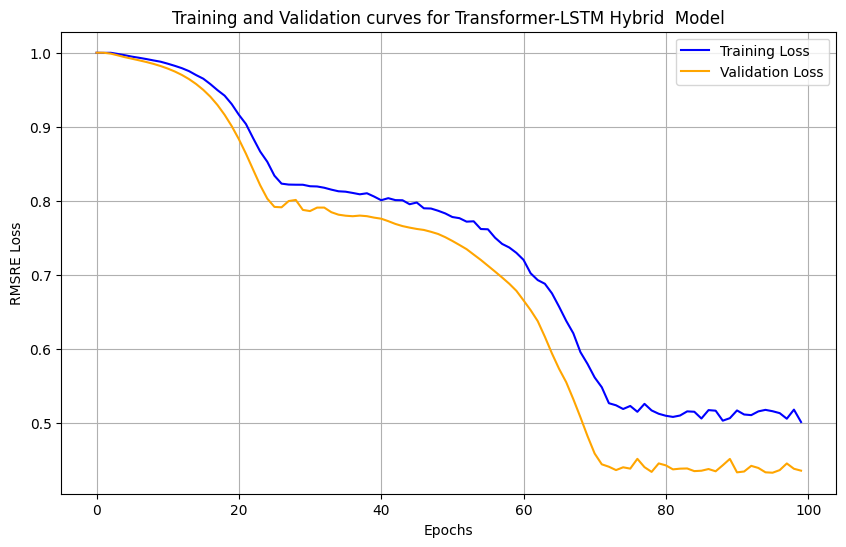

In [272]:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('RMSRE Loss')
plt.title(f'Training and Validation curves for Transformer-LSTM Hybrid  Model')
plt.legend()
plt.grid(True)
plt.show()

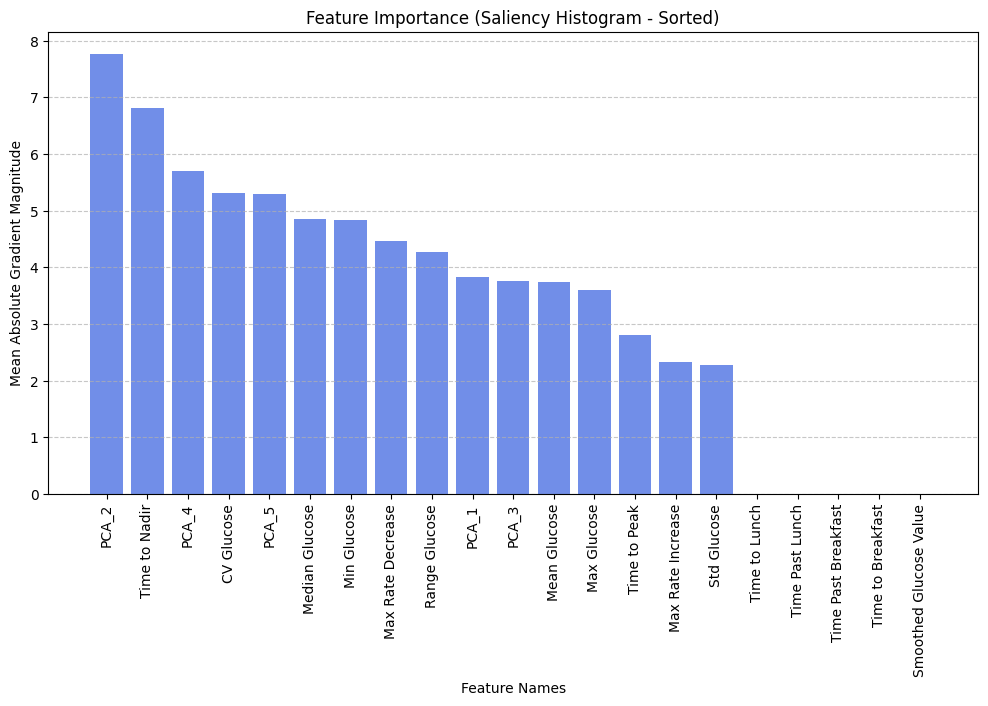

In [273]:
import matplotlib.pyplot as plt
import numpy as np


static_features = [
    #'Breakfast Time', 'Lunch Time',
    #'Breakfast Calories', 'Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein',
    'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose',
    'Median Glucose', 'Range Glucose', 'CV Glucose',
    'Max Rate Increase', 'Max Rate Decrease', 'Time to Peak', 'Time to Nadir',
    'PCA_1',    'PCA_2',     'PCA_3',     'PCA_4',     'PCA_5'
] 
dynamic_features = ['Smoothed Glucose Value', 'Time to Breakfast', 'Time Past Breakfast',  'Time to Lunch',  'Time Past Lunch']  #'Glucose Timestamp'

def plot_saliency_histogram(dynamic_gradients, static_gradients, dynamic_feature_names, static_feature_names):
    # Convert gradients to absolute values
    dynamic_gradients_abs = np.abs(dynamic_gradients.detach().cpu().numpy()).mean(axis=(0, 1))  # Averaging over batch & time
    static_gradients_abs = np.abs(static_gradients.detach().cpu().numpy()).mean(axis=0)  # Averaging over batch

    # Ensure correct array shapes
    dynamic_gradients_abs = dynamic_gradients_abs.flatten()
    static_gradients_abs = static_gradients_abs.flatten()

    # Combine static and dynamic features
    all_feature_names = static_feature_names + dynamic_feature_names
    all_gradients = np.concatenate([static_gradients_abs, dynamic_gradients_abs])

    # Ensure matching lengths
    assert len(all_feature_names) == len(all_gradients), "Mismatch between feature names and gradient values!"

    # Sort features by importance in descending order
    sorted_indices = np.argsort(all_gradients)[::-1]  # Get indices sorted in descending order
    sorted_gradients = all_gradients[sorted_indices]
    sorted_feature_names = [all_feature_names[i] for i in sorted_indices]

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(sorted_gradients)), sorted_gradients, color='royalblue', alpha=0.75)
    plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
    plt.xlabel("Feature Names")
    plt.ylabel("Mean Absolute Gradient Magnitude")
    plt.title("Feature Importance (Saliency Histogram - Sorted)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


dynamic_gradients, static_gradients = getGrad(model, X_dyn, X_stat)
#plot_dynamic_saliency_map(dynamic_gradients, dynamic_features)
#plot_static_saliency_map(static_gradients, static_features)
# Call the function with computed gradients
plot_saliency_histogram(dynamic_gradients, static_gradients, dynamic_features, static_features)



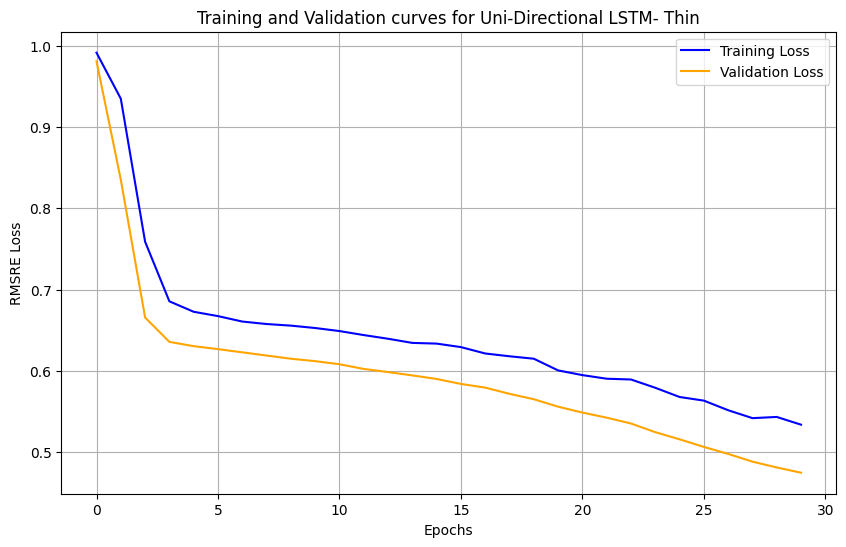

In [100]:
lstm_saved_models

best_lstm_model_key = min(saved_models, key=lambda key: saved_models[key]["val_losses"][-1])
best_model_data = lstm_thin_saved_models['lstm_thin_lr_0.001_batch_8_epochs_30']
train_losses = best_model_data["train_losses"]
val_losses = best_model_data["val_losses"]


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('RMSRE Loss')
plt.title(f'Training and Validation curves for Uni-Directional LSTM- Thin')
plt.legend()
plt.grid(True)
plt.show()

## Best Model for Transformer model
Learning Rate : 0.001
Validation Loss : 0.2909
Optimizer : Adam
LR Scheduler : 0.8x Every 10 steps
Epochs : 100


[0.43662092416427184, 0.4367243533866185, 0.606731045029112, 0.44475043989390883, 0.43888730313897445, 0.5763643586446574, 0.4728865836350783, 0.4379005772083756, 0.49616314550879576, 0.4578751398206117, 0.5847103478417286, 0.6483798711339028, 0.4475899204938232, 0.476409223891532, 0.636889229513512, 0.4476233897281977, 0.45166007612208936, 0.6334334862977925, 0.5975206122467677, 0.6325868929842277, 0.8047349386169841, 0.5541437146958681, 0.6173116457662056, 0.693792476586527, 0.45575268578104094, 0.6016057955486283, 0.642047953475453, 0.4747990355584269, 0.5922099539482065, 0.6812257845731574, 0.4430223831884221, 0.5390941268674906, 0.6501342247876994, 0.44238621578139764, 0.4978697885543433, 0.633971370951442, 0.629028906105622, 0.6505279275503548, 0.9941431459043221, 0.6197717265489118, 0.6368144750723244, 0.9668544020214578, 0.6035361311904117, 0.6330276341873197, 0.8963896431474967]
dict_keys(['lstm_lr_0.001_batch_8_epochs_30', 'lstm_lr_0.0005_batch_8_epochs_30', 'lstm_lr_0.0001_b

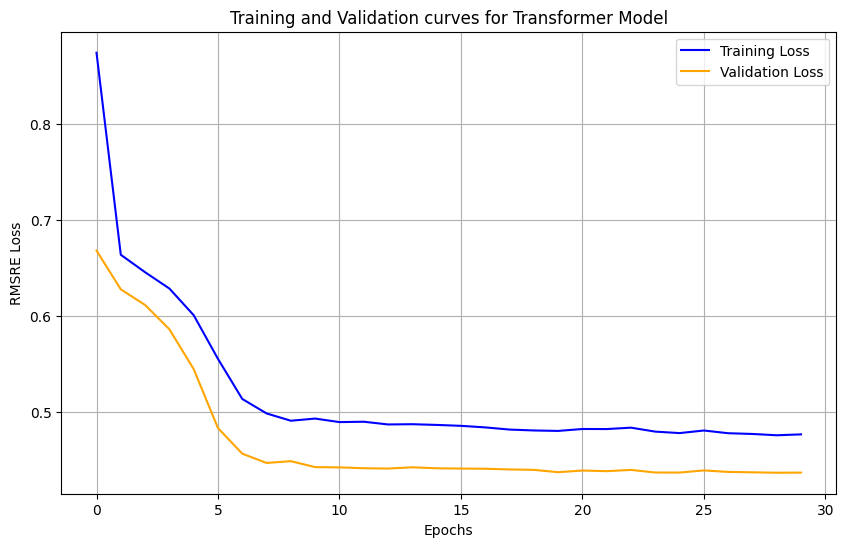

In [101]:


best_transformer_saved_models = saved_models

# Create an array of all the last validation losses (val_losses[-1]) for each model
last_val_losses = [best_transformer_saved_models[key]["val_losses"][-1] for key in saved_models]

# Print the array of last validation losses
print(last_val_losses)


print(best_transformer_saved_models.keys())

best_transformer_key = min(best_transformer_saved_models, key=lambda key: best_transformer_saved_models[key]["val_losses"][-1])
best_model_data = best_transformer_saved_models[best_transformer_key]
train_losses = best_model_data["train_losses"]
val_losses = best_model_data["val_losses"]


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('RMSRE Loss')
plt.title(f'Training and Validation curves for Transformer Model')
plt.legend()
plt.grid(True)
plt.show()

## Inference

Here we pick our Bi directional best model and run inference for the test data. The test data has gone through all the same processes as the train data after being processed through our data generation scripts.


We also account for the timestamp sequences not being uniform in the test data and pad it to 93 timesteps or truncate it as needed. Since all of them start at the same time this was not a problem in our training dataset


In [671]:
best_transformer_saved_models[best_transformer_key]['model']

OrderedDict([('positional_encoding',
              tensor([[ 0.3983, -0.6667,  0.0926,  ...,  0.3266, -0.3768, -0.6370],
                      [ 0.7752, -2.3098,  1.1384,  ...,  1.0343,  0.0445,  1.3571],
                      [-0.5431,  0.1702, -0.6916,  ..., -1.5294,  0.3756,  0.2367],
                      ...,
                      [ 0.4507, -0.2585, -1.3467,  ..., -0.2442,  1.5687,  0.1003],
                      [-0.3048,  0.8673,  1.5063,  ..., -0.6083,  0.2489,  0.6394],
                      [ 0.3605,  0.9044,  0.5147,  ...,  1.7752,  0.1936,  0.3837]])),
             ('static_fc.weight',
              tensor([[ 0.1477,  0.0489, -0.2218,  ...,  0.1980,  0.1680, -0.0702],
                      [ 0.2294, -0.0556, -0.1182,  ...,  0.0541, -0.1298, -0.1560],
                      [-0.0753, -0.0630, -0.0190,  ..., -0.1929, -0.0034, -0.1945],
                      ...,
                      [ 0.2337,  0.1801,  0.2142,  ...,  0.0524, -0.1821,  0.1472],
                      [ 0.2163, 

In [679]:
bestLstm = LSTMModel(5,16)
best_lstm_bi = lstm_saved_models['lstm_lr_0.001_batch_8_epochs_30']
model_weights = best_lstm_bi['model']
bestLstm.load_state_dict(model_weights)  # Load the weights
bestLstm.eval()  # Set the model to evaluation mode (important for inference)

best_lstm_bi_predictions = []

with torch.no_grad():
    for X_dyn, X_stat in test_loader2:
        # Move inputs to the appropriate device
        X_dyn, X_stat = X_dyn.to(device), X_stat.to(device)
        
        # Get the current sequence length
        current_length = X_dyn.shape[1]  # The sequence length is the second dimension
        
        if current_length < 93:
            # Pad sequences shorter than 93
            pad_size = 93 - current_length
            padding = torch.zeros((X_dyn.shape[0], pad_size, X_dyn.shape[2])).to(device)
            X_dyn = torch.cat((X_dyn, padding), dim=1)  # Pad along the sequence length dimension
        elif current_length > 93:
            # Truncate sequences longer than 93
            X_dyn = X_dyn[:, :93, :]  # Keep only the first 93 timesteps
        
        # Perform prediction
        preds = bestLstm(X_dyn, X_stat).squeeze().cpu().numpy()
        best_lstm_bi_predictions.append(preds)

In [663]:
best_lstm_bi_predictions = pd.DataFrame({
    'row_id': range(len(best_lstm_bi_predictions)),  # Create a sequential index for row_id
    'label': best_lstm_bi_predictions
})

# Display the DataFrame
print(best_lstm_bi_predictions)

    row_id      label
0        0   527.0613
1        1  526.50305
2        2   525.0852
3        3    525.665
4        4  526.84717
..     ...        ...
68      68   354.0544
69      69  450.83496
70      70   462.1396
71      71  389.60095
72      72   372.2259

[73 rows x 2 columns]


In [664]:
best_lstm_bi_predictions.to_csv('Skynet_best_bidirectional_lstm.csv',index=False)


In [687]:
bestTransformer_model = TransformerModel(16,5,93)
best_Transformer = best_transformer_saved_models['transformer_lr_0.001_batch_8_epochs_100']
model_weights = best_Transformer['model']
bestTransformer_model.load_state_dict(model_weights)  # Load the weights
bestTransformer_model.eval()  # Set the model to evaluation mode (important for inference)

best_transformer_predictions = []

with torch.no_grad():
    for X_dyn, X_stat in test_loader2:
        # Move inputs to the appropriate device
        X_dyn, X_stat = X_dyn.to(device), X_stat.to(device)
        
        # Get the current sequence length
        current_length = X_dyn.shape[1]  # The sequence length is the second dimension
        
        if current_length < 93:
            # Pad sequences shorter than 93
            pad_size = 93 - current_length
            padding = torch.zeros((X_dyn.shape[0], pad_size, X_dyn.shape[2])).to(device)
            X_dyn = torch.cat((X_dyn, padding), dim=1)  # Pad along the sequence length dimension
        elif current_length > 93:
            # Truncate sequences longer than 93
            X_dyn = X_dyn[:, :93, :]  # Keep only the first 93 timesteps
        
        # Perform prediction
        preds = bestTransformer_model(X_dyn, X_stat).squeeze().cpu().numpy()
        best_transformer_predictions.append(preds)

/opt/anaconda3/envs/myl6332/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [688]:
best_transformer_predictions = pd.DataFrame({
    'row_id': range(len(best_transformer_predictions)),  # Create a sequential index for row_id
    'label': best_transformer_predictions
})

# Display the DataFrame
print(best_transformer_predictions)

    row_id      label
0        0    445.243
1        1  445.24295
2        2  445.24298
3        3  445.24298
4        4  445.24298
..     ...        ...
68      68  445.24298
69      69  445.24292
70      70  445.24292
71      71  445.24295
72      72  445.24292

[73 rows x 2 columns]


In [689]:
best_transformer_predictions.to_csv('Skynet_best_transformer.csv',index=False)

Pickle and save the model

In [665]:
import pickle

model_filename = 'Skynet_best_bidirectional_lstm.pickle'

with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_filename}")

Model saved to Skynet_best_bidirectional_lstm.pickle


In [690]:
model_filename = 'Skynet_best_transformer.pickle'

with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_filename}")

Model saved to Skynet_best_transformer.pickle


# Looking at feature importance 

In our earlier grid searches we saw that the models were overly indexed on the breakfast macros through vizualizations of saliency maps.  Since we know the set up of the experiment and how this can lead to memorization we decided to exclude these macros from the prediction and only include the time relations to breakfast in order to generalize the model better in our final code.

Given the below maps we can see the dynamic features are highly indexed on the glucose values which is ideal. We also see the heavy reliance on the statistical features of glucose.




In [184]:
model

LSTMModelThin(
  (lstm): LSTM(5, 32, batch_first=True)
  (static_branch): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)

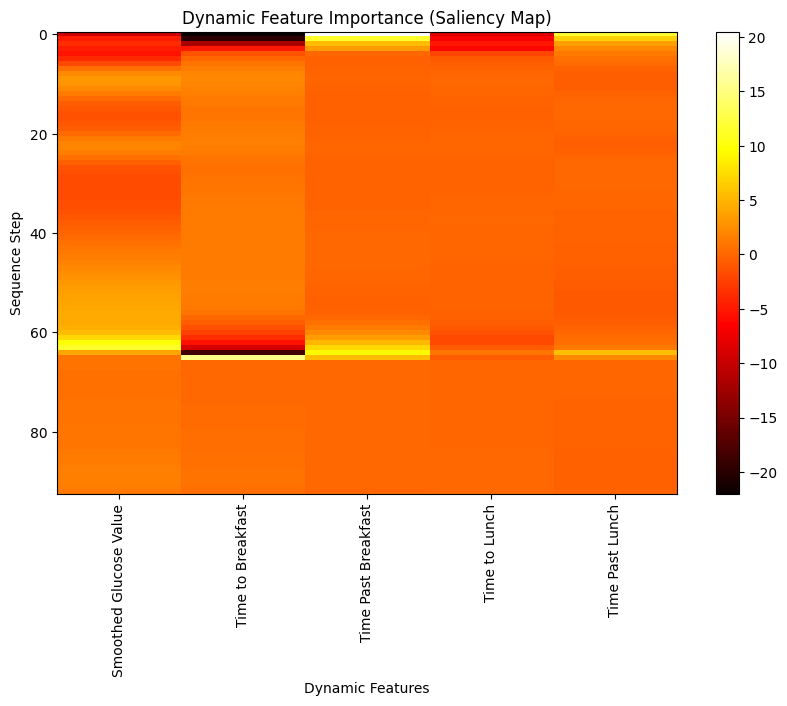

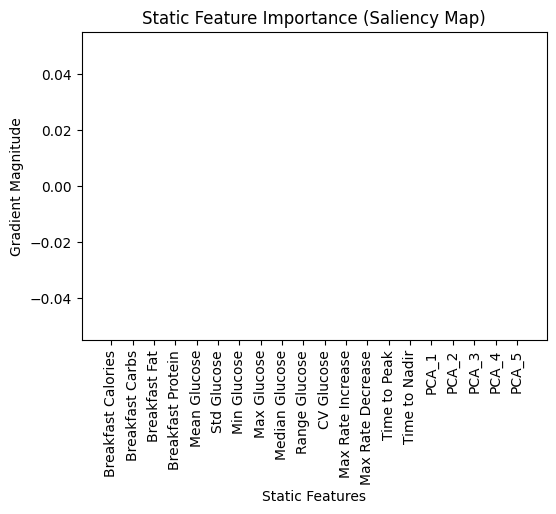

In [190]:

# Final Included features
static_features = [
    #'Breakfast Time', 'Lunch Time',
    'Breakfast Calories', 'Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein',
    'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose',
    'Median Glucose', 'Range Glucose', 'CV Glucose',
    'Max Rate Increase', 'Max Rate Decrease', 'Time to Peak', 'Time to Nadir',
    'PCA_1',    'PCA_2',     'PCA_3',     'PCA_4',     'PCA_5'
] 
dynamic_features = ['Smoothed Glucose Value', 'Time to Breakfast', 'Time Past Breakfast',  'Time to Lunch',  'Time Past Lunch']  #'Glucose Timestamp'

#Get gradients for Saliency maps
def getGrad(model, dynamic_input, static_input):
    model.eval()
    dynamic_input = dynamic_input.clone().detach().requires_grad_(True)
    static_input = static_input.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(dynamic_input, static_input)
    
    # Aggregate output to a scalar (e.g., sum, mean, or use a specific element)
    scalar_output = output.sum()  # Example: sum of all outputs

    # Backward pass
    scalar_output.backward()

    # Extract gradients
    dynamic_gradients = dynamic_input.grad
    static_gradients = static_input.grad

    return dynamic_gradients, static_gradients

def plot_dynamic_saliency_map(dynamic_gradients, dynamic_feature_names):
    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_gradients[0], cmap='hot', aspect='auto')
    plt.colorbar()
    plt.xticks(range(dynamic_gradients.shape[2]), dynamic_feature_names, rotation=90)
    plt.xlabel('Dynamic Features')
    plt.ylabel('Sequence Step')
    plt.title("Dynamic Feature Importance (Saliency Map)")
    plt.show()

def plot_static_saliency_map(static_gradients, static_feature_names):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(static_gradients[0])), static_gradients[0])
    plt.xticks(range(len(static_feature_names)), static_feature_names, rotation=90)
    plt.xlabel("Static Features")
    plt.ylabel("Gradient Magnitude")
    plt.title("Static Feature Importance (Saliency Map)")
    plt.show()


# Sample inputs from loaders

#Random Input 
dynamic_input = X_dyn 
static_input = X_stat 
#model = bestLstm

# Compute feature importance (dynamic and static gradients)
dynamic_gradients, static_gradients = getGrad(model, dynamic_input, static_input)
plot_dynamic_saliency_map(dynamic_gradients, dynamic_features)
plot_static_saliency_map(static_gradients, static_features)



In [189]:
static_gradients.shape

torch.Size([13, 20])

In [165]:
len(dynamic_features)

5

In [164]:
len(dynamic_gradients)

29